# Спринт 10 «Обучение с учителем»

# Проект «Отток клиентов»

## Навигация

1. [Описание проекта](#Описание-проекта)
1. [Описание данных](#Описание-данных)
1. [Предобработка данных](#Предобработка-данных)
1. [Борьба с дисбалансом](#Борьба-с-дисбалансом)
1. [Тестирование модели](#Тестирование-модели)
1. [Общие выводы](#Общие-выводы)

## Описание проекта

[к навигации](#Навигация)

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных

[к навигации](#Навигация)

**Признаки**
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**
- `Exited` — факт ухода клиента

In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

In [2]:
RANDOM_STATE = 42

In [3]:
data = pd.read_csv(
    os.path.join('..', 'datasets', 'Churn.csv'),
    dtype={
        'Geography': 'category',
        'Gender': 'category',
    },
)
data = data.rename(columns={
    'RowNumber': 'row_number',
    'CustomerId': 'customer_id',
    'Surname': 'surname',
    'CreditScore': 'credit_score',
    'Geography': 'geography',
    'Gender': 'gender',
    'Age': 'age',
    'Tenure': 'tenure',
    'Balance': 'balance',
    'NumOfProducts': 'num_of_products',
    'HasCrCard': 'has_cr_card',
    'IsActiveMember': 'is_active_member',
    'EstimatedSalary': 'estimated_salary',
    'Exited': 'exited',
})
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   row_number        10000 non-null  int64   
 1   customer_id       10000 non-null  int64   
 2   surname           10000 non-null  object  
 3   credit_score      10000 non-null  int64   
 4   geography         10000 non-null  category
 5   gender            10000 non-null  category
 6   age               10000 non-null  int64   
 7   tenure            9091 non-null   float64 
 8   balance           10000 non-null  float64 
 9   num_of_products   10000 non-null  int64   
 10  has_cr_card       10000 non-null  int64   
 11  is_active_member  10000 non-null  int64   
 12  estimated_salary  10000 non-null  float64 
 13  exited            10000 non-null  int64   
dtypes: category(2), float64(3), int64(8), object(1)
memory usage: 957.3+ KB


In [5]:
data.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Предобработка данных

[к навигации](#Навигация)

Выбросим столбцы, что не могут быть признаками для обучения, т.е. `row_number`, `surname`, 
`customer_id`.

In [6]:
data = data.drop(columns=['row_number', 'surname', 'customer_id'])

Бинарная классификация на табличных данных -> используем RandomForestClassifier.  
(Хорошо бы какой-нибудь GBDT, например, CatBoost, но пока мы подобные модели не проходили)

Для моделей на DT масштабирование не требуется, его проводить и не будем.

Есть пропуски в признаке `tenure`. А RandomForestClassifier не умеет их обрабатывать. Заменим их на `-1`.

In [7]:
data['tenure'] = data['tenure'].replace({np.NaN: -1})

Категориальные признаки закодируем через OHE.

In [8]:
data = pd.get_dummies(data, columns=['gender', 'geography'], drop_first=True)
data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_Male,geography_Germany,geography_Spain
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


## Исследование задачи

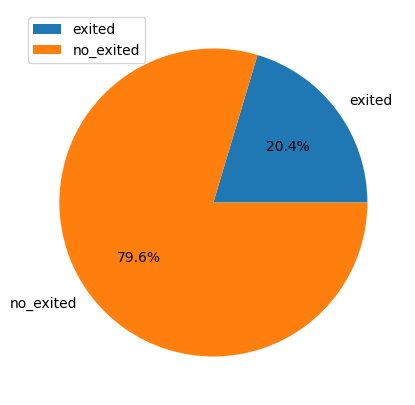

In [9]:
exited_size = (data['exited'] == 1).sum()
no_exited_size = (data['exited'] == 0).sum()

fig, ax = plt.subplots(figsize=(5, 5))

ax.pie([exited_size, no_exited_size], labels=['exited', 'no_exited'], autopct='%1.1f%%')
ax.legend();

In [10]:
y = data['exited']
X = data.drop(columns='exited')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    random_state=RANDOM_STATE,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    stratify=y_train,
    random_state=RANDOM_STATE,
)

In [12]:
best_depth = None
best_f1 = -1
best_auc = None
for depth in range(2, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_prob)

    print(f'глубина\t{depth},\tf1 {f1:.3},\tauc {auc:.3}')

    if best_f1 < f1:
        best_f1 = f1
        best_depth = depth
        best_auc = auc

print(f'Лучшая глубина\t{best_depth},\tf1 {best_f1:.3},\tauc {best_auc:.3}')

глубина	2,	f1 0.488,	auc 0.737
глубина	3,	f1 0.406,	auc 0.787
глубина	4,	f1 0.514,	auc 0.817
глубина	5,	f1 0.538,	auc 0.834
глубина	6,	f1 0.559,	auc 0.832
глубина	7,	f1 0.546,	auc 0.827
глубина	8,	f1 0.567,	auc 0.823
глубина	9,	f1 0.571,	auc 0.807
глубина	10,	f1 0.584,	auc 0.799
глубина	11,	f1 0.576,	auc 0.774
глубина	12,	f1 0.553,	auc 0.749
глубина	13,	f1 0.539,	auc 0.731
глубина	14,	f1 0.548,	auc 0.725
глубина	15,	f1 0.554,	auc 0.73
глубина	16,	f1 0.547,	auc 0.725
глубина	17,	f1 0.54,	auc 0.715
глубина	18,	f1 0.539,	auc 0.718
глубина	19,	f1 0.54,	auc 0.717
глубина	20,	f1 0.545,	auc 0.719
Лучшая глубина	10,	f1 0.584,	auc 0.799


In [13]:
best_depth = None
best_f1 = -1
best_auc = None
for depth in range(2, 21):
    model = RandomForestClassifier(max_depth=depth, n_jobs=-1, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_prob)

    print(f'глубина\t{depth},\tf1 {f1:.3},\tauc {auc:.3}')

    if best_f1 < f1:
        best_f1 = f1
        best_depth = depth
        best_auc = auc

print(f'Лучшая глубина\t{best_depth},\tf1 {best_f1:.3},\tauc {best_auc:.3}')

глубина	2,	f1 0.109,	auc 0.812
глубина	3,	f1 0.257,	auc 0.822
глубина	4,	f1 0.383,	auc 0.835
глубина	5,	f1 0.455,	auc 0.844
глубина	6,	f1 0.512,	auc 0.852
глубина	7,	f1 0.546,	auc 0.857
глубина	8,	f1 0.552,	auc 0.858
глубина	9,	f1 0.549,	auc 0.859
глубина	10,	f1 0.56,	auc 0.859
глубина	11,	f1 0.573,	auc 0.86
глубина	12,	f1 0.578,	auc 0.861
глубина	13,	f1 0.585,	auc 0.856
глубина	14,	f1 0.591,	auc 0.856
глубина	15,	f1 0.578,	auc 0.858
глубина	16,	f1 0.573,	auc 0.856
глубина	17,	f1 0.592,	auc 0.863
глубина	18,	f1 0.592,	auc 0.858
глубина	19,	f1 0.583,	auc 0.857
глубина	20,	f1 0.576,	auc 0.854
Лучшая глубина	17,	f1 0.592,	auc 0.863


- Лучший f1-score получается у модели на RandomForestClassifier с глубиной деревьев 17.
- Однако разница между лучшим RandomForestClassifier и DecisionTreeClassifier небольшая

## Борьба с дисбалансом

[к навигации](#Навигация)

С дисбалансом борюсь с помощью балансировки весов.

In [14]:
%%time
grid_search = GridSearchCV(
    RandomForestClassifier(
        class_weight='balanced',
        random_state=RANDOM_STATE,
    ),
    param_grid={
        'max_depth': list(range(2, 20)),
    },
    scoring='f1',
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        test_size=0.25,
        random_state=RANDOM_STATE,
    ),
)
grid_search.fit(X_train, y_train)

CPU times: total: 969 ms
Wall time: 28.6 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.25,
            train_size=None),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19]},
             scoring='f1')

In [15]:
print(grid_search.best_score_)

0.5962432673672675


Есть ещё вариант балансировки через upsampling. Если делать, как учили на курсе, то есть тупо копированием точек данных класса, что меньше по объёму, то это сводиться к выше указанной балансировке через веса.  
Если балансировать через downsampling, опять же вариантом тупо случайной подвыборки точек данных класса, что больше, это очевидно снизит перфоманс модели.

Более сложные техники upsampling и downsampling выходят за рамки курса.

In [16]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=RANDOM_STATE)

    return features_upsampled, target_upsampled

In [17]:
X_train, y_train = upsample(X_train, y_train, repeat=5)

In [18]:
%%time
grid_search = GridSearchCV(
    RandomForestClassifier(
        random_state=RANDOM_STATE,
    ),
    param_grid={
        'max_depth': list(range(2, 20)),
    },
    scoring='f1',
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        test_size=0.25,
        random_state=RANDOM_STATE,
    ),
)
grid_search.fit(X_train, y_train)

CPU times: total: 1.88 s
Wall time: 38.2 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.25,
            train_size=None),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19]},
             scoring='f1')

In [19]:
print(grid_search.best_score_)

0.9594658121459088


## Тестирование модели

[к навигации](#Навигация)

In [20]:
model = grid_search.best_estimator_

In [21]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

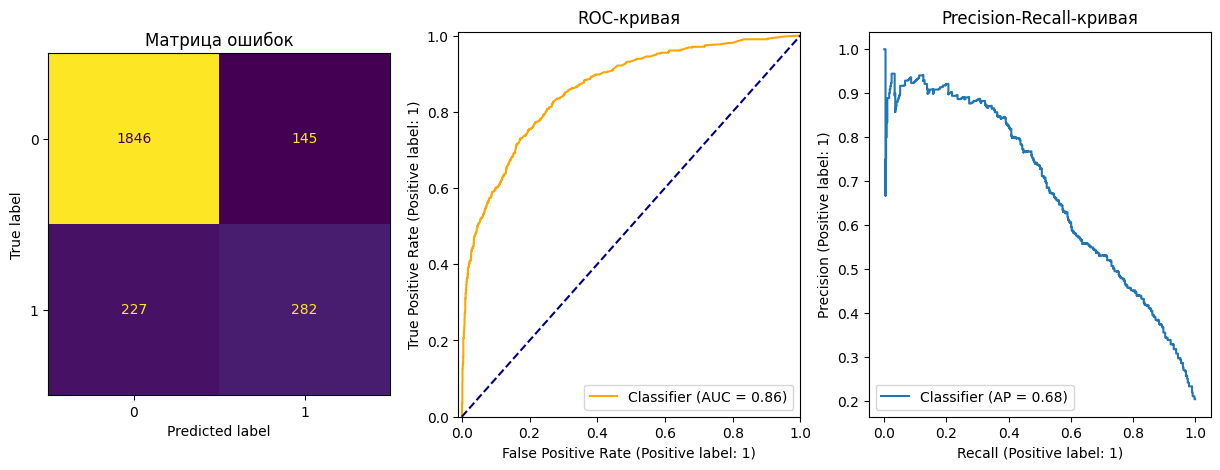

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1991
           1       0.66      0.55      0.60       509

    accuracy                           0.85      2500
   macro avg       0.78      0.74      0.76      2500
weighted avg       0.84      0.85      0.85      2500



In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=axes[0],
    colorbar=False,
)
axes[0].set(title='Матрица ошибок')

RocCurveDisplay.from_predictions(
    y_test, y_proba,
    ax=axes[1],
    color='orange',
)
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set(title='ROC-кривая', xlim=(-0.01, 1), ylim=(0, 1.01))

PrecisionRecallDisplay.from_predictions(
    y_test, y_proba,
    ax=axes[2],
)
axes[2].set(title='Precision-Recall-кривая')

plt.show()

print(classification_report(y_test, y_pred))

## Общие выводы

[к навигации](#Навигация)

- Рассмотрели в качестве базового классификатора DT и RF, выбрали RF
- Попробовали 2 варианта балансировки: через class_weights и upsampling. Лучше оказался upsampling
- Провели тестирование лучшей модели